# 

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx

In [2]:
os.chdir('C:/Users/user/Desktop/Darui_R08621110')
furnace = pd.read_csv('MDS_Assignment1_furnace.csv')
census = pd.read_csv('MDS_Assignment1_census.csv', header = None)
groceries = pd.read_csv('MDS_Assignment1_groceries.csv', header = None, sep = '\n')
grocery = groceries[0].str.split(',', expand = True)

## a

In [3]:
X = furnace.iloc[:, :-1]
y = furnace.grade
X = sm.add_constant(X)
result = sm.OLS(y, X).fit()
result.summary().as_text

<bound method Summary.as_text of <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                  grade   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     21.52
Date:                Thu, 21 Oct 2021   Prob (F-statistic):           1.16e-70
Time:                        22:38:36   Log-Likelihood:                -381.52
No. Observations:                 620   AIC:                             819.0
Df Residuals:                     592   BIC:                             943.1
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

## c

In [4]:
result.pvalues[result.pvalues < 0.01].sort_values()

const    0.000000e+00
f18      6.355895e-19
f2       2.430368e-18
f14      6.896905e-18
f15      3.971326e-08
f22      4.429125e-04
f17      6.967770e-04
f25      7.041639e-04
f6       6.295708e-03
dtype: float64

## d

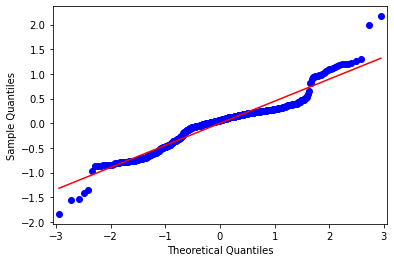

In [5]:
### normality
qq = sm.qqplot(result.resid, line = 's')

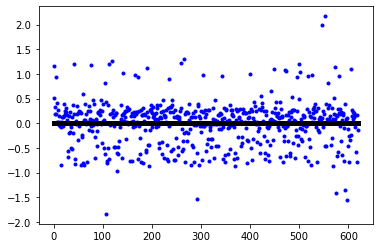

In [6]:
### independence
plt.plot(result.resid, 'b.')
plt.plot([0, len(result.resid)], [0, 0], 'k-', lw = 5)

In [7]:
### equal variance
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(result.resid, result.model.exog)
dict(zip(name, test))

{'Lagrange multiplier statistic': 140.62034965182642,
 'p-value': 5.871842930105079e-17,
 'f-value': 6.431710999631288,
 'f p-value': 5.311815675352639e-20}

# 

In [8]:
census = census.rename(columns = {14: 'label'})
census.label = (census.label == ' >50K').astype(int)
census.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
                  'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 
                  'label']
for i in census.columns.to_list():
    census[i] = census[i].replace({' ?': None}) 

## a

In [9]:
### continous
continuous = [0, 2, 4, 10, 11, 12]
cont_stat = census.iloc[:, continuous].describe()
cont_miss = [sum(census.iloc[:, x].isnull().astype(int)) for x in continuous]
cont_stat.loc['missing'] = cont_miss
cont_stat

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000
missing,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000


In [17]:
### category
category = [1, 3, 5, 6, 7 ,8 , 9, 13]
cate_miss = [sum(census.iloc[:, x].isnull().astype(int)) for x in category]
cate_stat = census.iloc[:, category].describe()
cate_stat.loc['missing'] = cate_miss
cate_stat

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
count,30725,32561,32561,30718,32561,32561,32561,31978
unique,8,16,7,14,6,5,2,41
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
freq,22696,10501,14976,4140,13193,27816,21790,29170
missing,1836,0,0,1843,0,0,0,583


## b, c

In [10]:
### multivariate outlier (by mahalanobis distance)
data = census.iloc[:, continuous].to_numpy()
covariance = np.cov(data, rowvar = False)
covariance_p = np.linalg.matrix_power(covariance, -1)
center = np.mean(data, axis = 0)

distance = []
for i, value in enumerate(data):
    dist = (value - center).T.dot(covariance_p).dot(value - center)
    distance.append(dist)
distance = np.array(distance)

cutoff = stats.chi2.ppf(0.999, data.shape[1])
outlier = np.where(distance >= cutoff)
print(outlier[0])
len(outlier[0])

[   23    52    96 ... 32494 32518 32531]


1215

In [11]:
### one-hot encoding
new_census = pd.get_dummies(census, drop_first = True)
label = new_census.label
del new_census['label']
new_census['label'] = label

In [12]:
### missing value imputation
imputer = KNNImputer(n_neighbors = 5, weights = 'uniform')
imputation = imputer.fit_transform(new_census)
done_census = pd.DataFrame(imputation, columns = new_census.columns)

## d

In [13]:
length = len(done_census)
inds = np.arange(length)
np.random.shuffle(inds)
train_len = np.floor(0.75*length).astype(int)
train_index = inds[:train_len]
test_index = inds[train_len:]
train_data = done_census.loc[train_index]
test_data = done_census.loc[test_index]

## e

In [14]:
train_x = train_data.iloc[:, :-1]
train_y = train_data.label
test_x = test_data.iloc[:, :-1]
test_y = test_data.label
clf = LogisticRegression()
clf.fit(train_x, train_y)
predict = clf.predict(test_x)
error = abs(predict - test_y)
accuracy = (len(test_y) - sum(error)) / len(test_y)
accuracy

0.7937599803463948

# 

## a

In [15]:
data = grocery.to_numpy()
strip_data = []
for i in range(data.shape[0]):
    row = data[i]
    new_row = list(row[row != np.array(None)])
    strip_data.append(new_row)
    
te = TransactionEncoder()
trans_data = te.fit(strip_data).transform(strip_data)
trans_df = pd.DataFrame(trans_data, columns = te.columns_)

## b

In [19]:
apriori_df = apriori(trans_df, min_support = 0.001, use_colnames = True)
rule = association_rules(apriori_df, metric = 'confidence', min_threshold = 0.15)
rule = rule.sort_values('lift', ascending = False)
rule.iloc[:5, :]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2430,(liquor),"(bottled beer, red/blush wine)",0.011083,0.004881,0.001932,0.174312,35.715787,0.001878,1.205200
2429,"(bottled beer, red/blush wine)",(liquor),0.004881,0.011083,0.001932,0.395833,35.715787,0.001878,1.636828
32661,"(oil, whole milk, tropical fruit)","(yogurt, other vegetables, root vegetables)",0.002542,0.012913,0.001017,0.400000,30.976378,0.000984,1.645145
32657,"(oil, root vegetables, yogurt)","(other vegetables, whole milk, tropical fruit)",0.001932,0.017082,0.001017,0.526316,30.811404,0.000984,2.075049
32537,"(yogurt, domestic eggs, other vegetables, whol...","(tropical fruit, butter)",0.003355,0.009964,0.001017,0.303030,30.411255,0.000983,1.420486


## d
##### draw_graph function from https://www.kaggle.com/yugagrawal95/market-basket-analysis-apriori-in-python

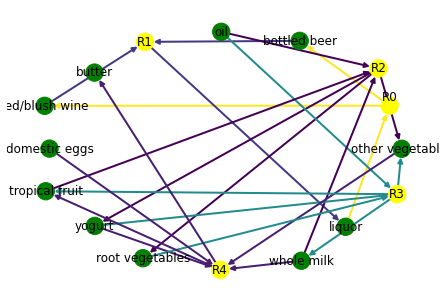

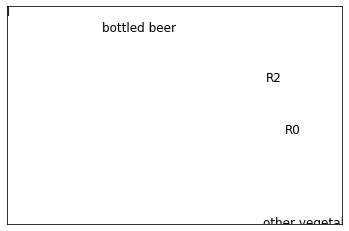

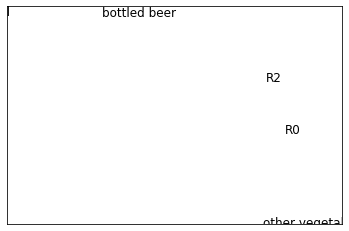

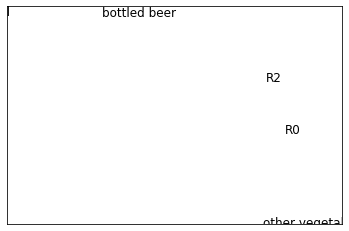

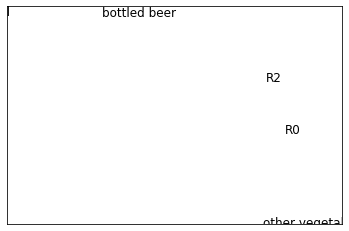

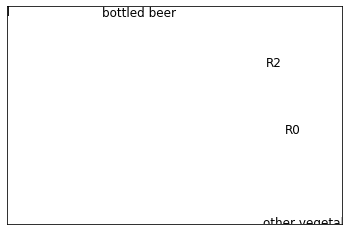

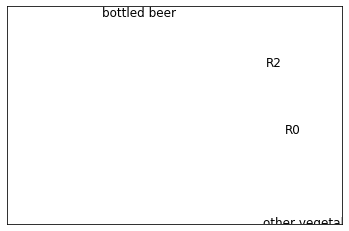

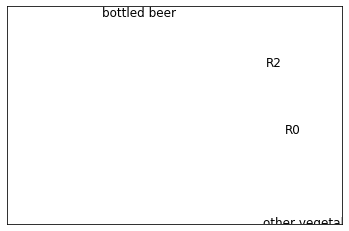

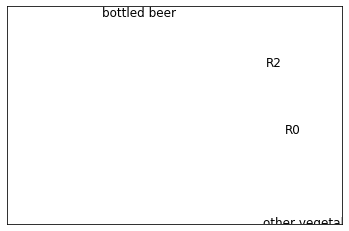

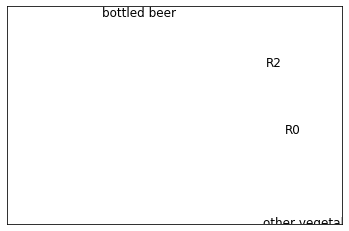

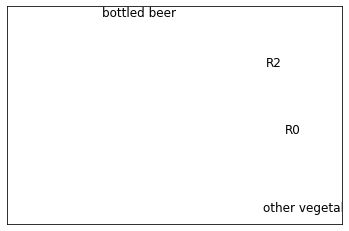

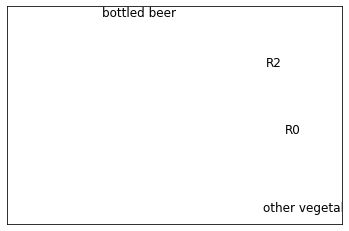

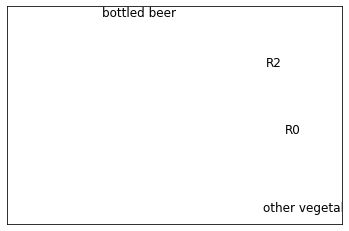

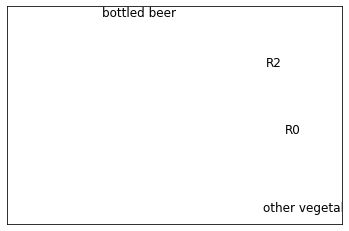

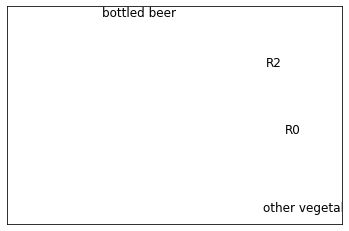

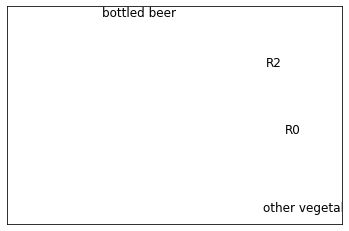

In [22]:
def draw_graph(rules, rules_to_show):
    G1 = nx.DiGraph()
    color_map=[]
    N = 50
    colors = np.random.rand(N)    
    strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']

    for i in range(rules_to_show):
        G1.add_nodes_from(["R"+str(i)])
        for a in rules.iloc[i]['antecedents']:
            G1.add_nodes_from([a])
            G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)
        for c in rules.iloc[i]['consequents']:
            G1.add_nodes_from([c])
            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)

    for node in G1:
        found_a_string = False
        for item in strs: 
            if node==item:
                found_a_string = True
        if found_a_string:
            color_map.append('yellow')
        else:
            color_map.append('green')       

    edges = G1.edges()
    colors = [G1[u][v]['color'] for u,v in edges]
    weights = [G1[u][v]['weight'] for u,v in edges]

    pos = nx.spring_layout(G1, k=16, scale=1)
    nx.draw(G1, pos, node_color = color_map, edge_color=colors, width=weights, font_size=16, 
            with_labels=False)            

    for p in pos:  # raise text positions
        pos[p][1] += 0.07
        nx.draw_networkx_labels(G1, pos)
        plt.show()

        
        
draw_graph (rule, 5)